<a href="https://colab.research.google.com/github/JeLaKo/apple-tree-disease/blob/main/Milestone3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import mlxtend package for confusion matrix
import mlxtend
                                                          
print(mlxtend.__version__) 

! pip install mlxtend --upgrade --no-deps

print(mlxtend.__version__) 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


0.19.0
0.19.0


Loading the data directly through Kaggle's API

In [3]:
# connect to google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
# install kaggle
!pip install -U -q kaggle==1.5.8

In [5]:
#change to appropriate directory in google drive
%cd /content/gdrive/MyDrive/MLP/

/content/gdrive/MyDrive/MLP


In [6]:
# import os for kaggle
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/MLP/"
! kaggle competitions download -c plant-pathology-2021-fgvc8

  7% 1.11G/14.9G [00:10<02:07, 116MB/s]
User cancelled operation


In [ ]:
# quietly unzip plant pathology data
! unzip -q plant-pathology-2021-fgvc8.zip -d train

Data processing


In [7]:
# relevant imports for data processing
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

#change to appropriate directory in google drive
%cd /content/gdrive/MyDrive/MLP/train/

/content/gdrive/MyDrive/MLP/train


In [8]:
# create dataframe of relevant data
df = pd.read_csv('train.csv')


In [9]:
# deadling with combined data: set new labels for relevant classes after merge
new_labels = df['labels'].to_list()

# merge combined classes to main classes
for i in range(len(new_labels)):
  if new_labels[i] == 'scab frog_eye_leaf_spot complex' or new_labels[i] == 'scab frog_eye_leaf_spot':
    new_labels[i] = 'scab'
  elif new_labels[i] == 'frog_eye_leaf_spot complex':
    new_labels[i] = 'frog_eye_leaf_spot'
  elif new_labels[i] == 'powdery_mildew complex':
    new_labels[i] = 'powdery_mildew'
  elif new_labels[i] == 'rust complex' or new_labels[i] == 'rust frog_eye_leaf_spot':
    new_labels[i] = 'rust'


In [10]:
# adjust labels to labels merged with combined classes
df['adjusted labels'] = np.array(new_labels)
df = df.drop('labels', axis = 1)


In [11]:
def sample(df, sample_size):
  """
  This function gets an equal sample inclusive of all classes from the input dataframe
  """

  df_sampled = []
  classes = df['adjusted labels'].unique()

  for i in classes:
      g = df[df['adjusted labels'] == i].sample(sample_size)
      df_sampled.append(g)

  df_sampled = pd.concat(df_sampled)
  return df_sampled

df_sampled = sample(df, 1184)

                      image adjusted labels
17225  f880c7f58e806eea.jpg         healthy
18468  ff44c14087e917ad.jpg         healthy
1791   8e6a823cce9ff40c.jpg         healthy
16830  f59ad11bf1034d8a.jpg         healthy
2193   91a71de9b0b8725a.jpg         healthy
...                     ...             ...
3344   9ab326c1951acb7a.jpg  powdery_mildew
10261  c6d0873f7821676c.jpg  powdery_mildew
9655   c2cc858d98f3e687.jpg  powdery_mildew
8335   bb99253ce86153a9.jpg  powdery_mildew
11801  d25a929afc8d350b.jpg  powdery_mildew

[7104 rows x 2 columns]


In [12]:
def one_hot(df):
  """
  This function returns all classes and combination of classes found in the input-dataframe, and returns
  the one-hot encoded version
  """

  one_hot = pd.get_dummies(df['adjusted labels'])
  df = df.drop('adjusted labels', axis = 1)
  df = df.join(one_hot)
  return df

df_onehot = one_hot(df_sampled)

In [ ]:
# imports for training and evaluation
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing

In [37]:

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=80, augment={}):
    ''' Function trains and evaluates the model using training and validation data. 
        preprocessing and data augmentation possible as input. 
        outputs model loss and (avg.) model accuracy
    '''

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

In [14]:
# convert dictionary into a hashable type
df_dict = df_onehot.set_index('image').T.to_dict('list')

# gather names of all images in the image-directory
train_images = os.listdir('train_images/')

# # empty column for the actual images
# df_onehot["image_pixels"] = 0

images = []
# find corresponding key to image from directory, and add that image to a list
for image in df_dict.keys():
  if image in train_images:
    img = cv2.imread('train_images/' + image)
    img = cv2.resize(img, (96, 96)) 
    images.append(img)

labels = list(df_dict.values())

In [15]:
# create array for images and labels, used in train/test split function
images = np.array(images)
labels = np.array(labels)

In [16]:
# apply train/test split function
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.3, random_state=42)

In [1]:
# ML MODEL ARCHITECTURE

# Define Sequential model
model = models.Sequential()

# create convolutional layer and max pooling layer

model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# create convolutional layer (larger) and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 128 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 256 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
#model.add(layers.MaxPooling2D((2, 2)))

# # create convolutional layer (larger) and max pooling layer
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
# #model.add(layers.MaxPooling2D((2, 2)))

# add Conv2D layer with 32 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten layers
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.5)))

# apply softmax activation for final layer classification
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))

# normalize input data: set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# augment data: set augmentation dictionary
# augment = {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 20, 'width_shift_range': 0.1, 'height_shift_range': 0.1}
#augment = {'horizontal_flip': True}

# run training and evaluation function
train_and_evaluate(model, x_train, y_train, x_val, y_val, preprocess)

NameError: ignored

In [46]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_14 (Bat  (None, 24, 24, 64)      

In [19]:
# imports for confusion matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import math as tfmath

array(['healthy', 'scab', 'complex', 'rust', 'frog_eye_leaf_spot',
       'powdery_mildew'], dtype=object)

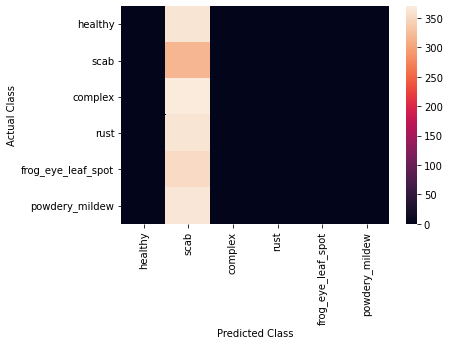

tf.Tensor(
[[  0 363   0   0   0   0]
 [  0 318   0   0   0   0]
 [  0 370   0   0   0   0]
 [  0 363   0   0   0   0]
 [  0 353   0   0   0   0]
 [  0 365   0   0   0   0]], shape=(6, 6), dtype=int32)


In [30]:
# set classes to labels for use in confusion matrix
classes = df['adjusted labels'].unique()
display(classes)

# set set validation and predicted classes for confusion matrix
y_true = tf.argmax(y_val, axis=1)
y_pred = tf.argmax(model(x_val), axis=1)

# create confusion matrix
conf_matrix = tfmath.confusion_matrix(y_true, y_pred, num_classes=6)
ax = sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

print(conf_matrix)

array(['healthy', 'scab', 'complex', 'rust', 'frog_eye_leaf_spot',
       'powdery_mildew'], dtype=object)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8ab309d810>)

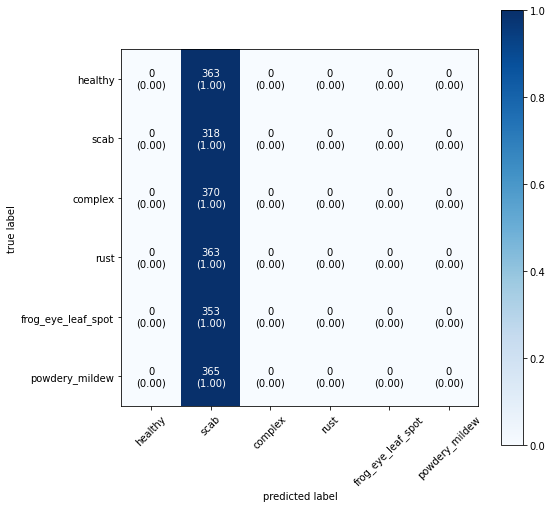

In [45]:
# define data for in confusion matrix
y_true = tf.argmax(y_val, axis=1)
y_pred = tf.argmax(model(x_val), axis=1)

# set labels for confusion matrix
labels =  df['adjusted labels'].unique()
display(labels)

# create and plot matrix
mtrx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat = mtrx, figsize=(8, 8), class_names=labels, colorbar=True, show_normed = True)